* contains the snippets of code by Matthew Chatham, Lee Clemmer, Pedro Marcelino, Lavanya Shukla, Masum Rumi and others from Kaggle and StackOverflow.

In [2]:
import pandas as pd
import numpy as np
import missingno as msno  # missing values visualization library
import matplotlib.pyplot as plt  # plots
import seaborn as sns  # plots
import pydotplus
import matplotlib.pyplot as plt   # create the decision tree images
import matplotlib.image as pltimg # create the decision tree images

#from numpy import arange

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.feature_selection import RFE  # Recursive Feature Elimination

from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer

from xgboost import XGBClassifier, XGBRegressor


## 0. Load the data

In [3]:
train = pd.read_csv('train.csv')

In [4]:
test = pd.read_csv('test.csv')

In [5]:
print('Training dataset has {0} features and {1} obsevrations'.format(train.shape[1], train.shape[0]))

Training dataset has 81 features and 1460 obsevrations


In [6]:
print('Test dataset has {0} features and {1} obsevrations'.format(test.shape[1], test.shape[0]))

Test dataset has 80 features and 1459 obsevrations


In [7]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [8]:
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


The test set does not have the 'SalePrice' [target] feature.

Id feature is unique for each observation and does not affect the sale price, therefore we can drop it from both train and test sets:

In [9]:
train.drop(['Id'], axis = 1, inplace = True)

In [10]:
test.drop(['Id'], axis = 1, inplace = True)

In [11]:
print('Training dataset has {0} features and {1} obsevrations'.format(train.shape[1], train.shape[0]))

Training dataset has 80 features and 1460 obsevrations


In [12]:
print('Test dataset has {0} features and {1} obsevrations'.format(test.shape[1], test.shape[0]))

Test dataset has 79 features and 1459 obsevrations


# 1. Dataset Explanation:

## 1.1 Summary statistics of the dataset

The summary statistics of the numeric features can be found below:

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print (train.describe())

        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315   
std      30.202904     20.645407   181.066207   456.098091   161.319273   
min    1872.000

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.describe(include=['object']))

       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1460         1460       1460       1460     1460       1460   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1382          225       1260       1445     1220        726   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460       1452      1460   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylS

## 1.2. Analysis of the attributes

The dataset consists of 79 numeric and categorical features describing the property. Most important features include:
    * Condition of the property
    * Square footage of the lot
    * Square footage of the house
    * Location (neighborhood)
    * Type of the dwelling
    * Existence and the size of the garage, etc.
The complete descirption of those features for brevity is provided in a separate document ('data_description.txt').

Obtain the info on the features in the dataframe, including:
* the name
* number of non-null variables
* data type

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## 1.3 Missing value investigation

Generate visual summary of present (black) and missing (white) values

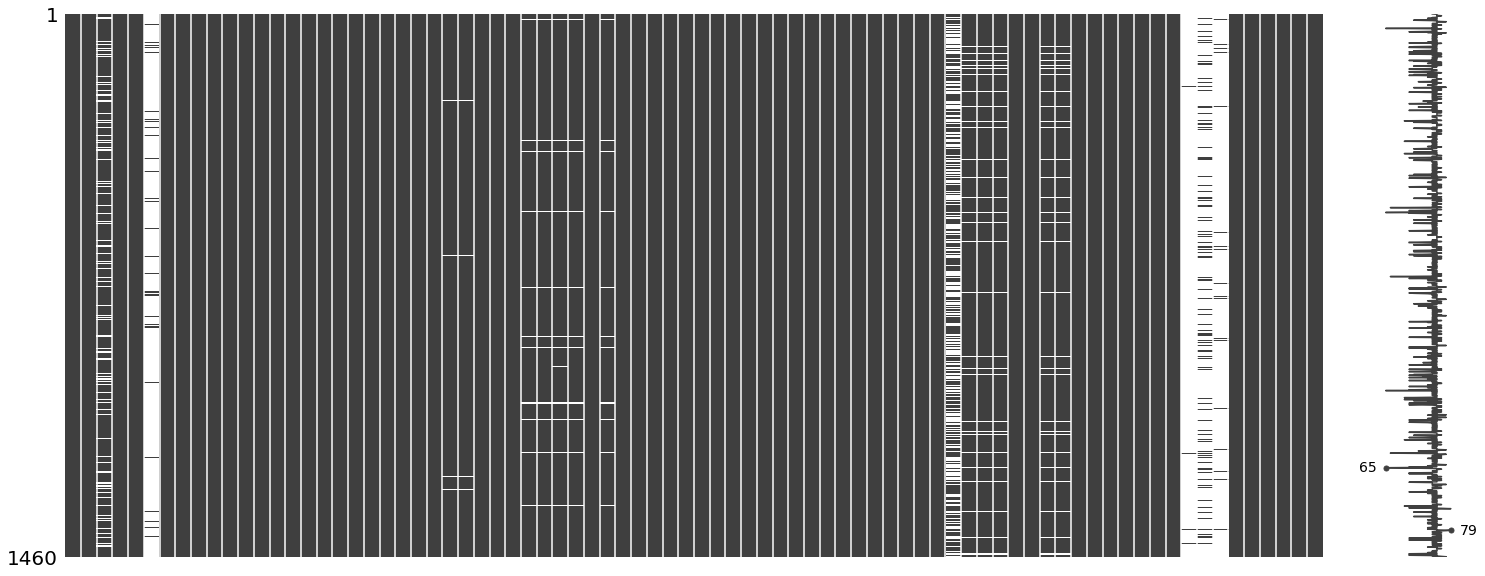

In [16]:
msno.matrix(train)

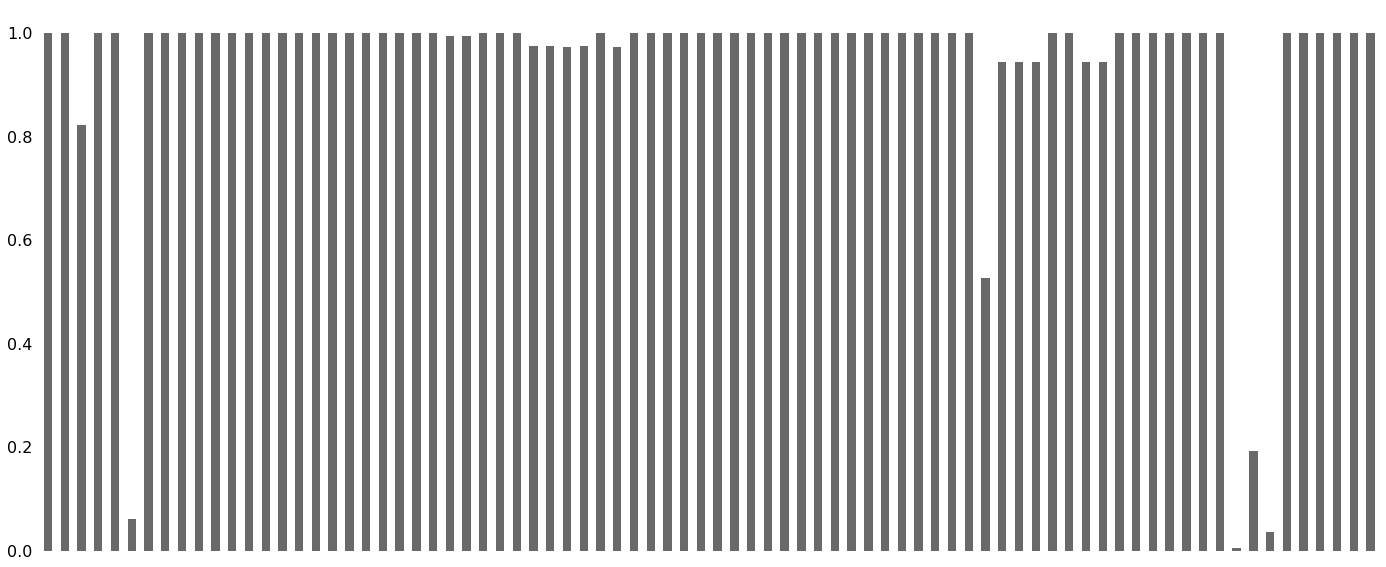

In [17]:
msno.bar(train)

Expore the nullity correlation: how strongly the presence or absence of one variable affects presence or absence of another variable:
* A value near -1 means if one variable appears then the other variable is very likely to be missing.
* A value near 0 means there is no dependence between the occurrence of missing values of two variables.
* A value near 1 means if one variable appears then the other variable is very likely to be present.

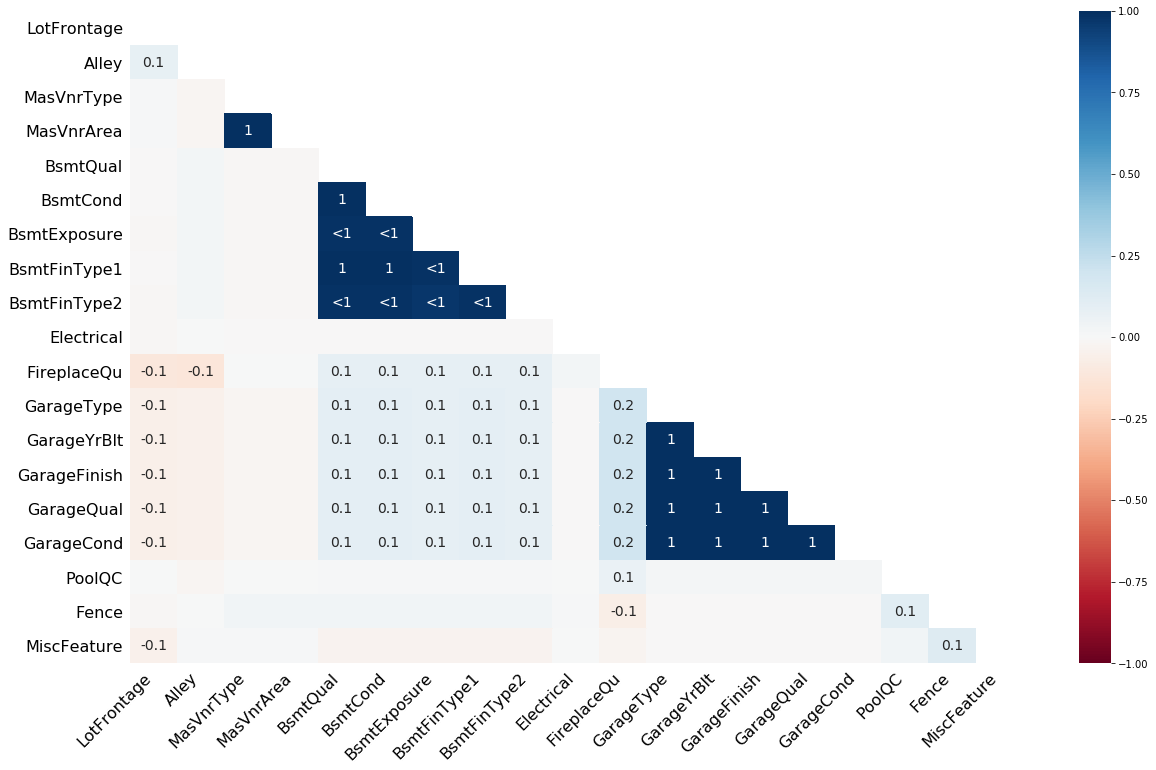

In [18]:
msno.heatmap(train)

## 1.4 Summarizing the dataset:

In [19]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [20]:
train.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


# 2. Data Preparation and Exploratory Analysis

## 2.1 Data Preparation and Cleansing

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Upon close inspection, some numerical features are in fact categorical:

In [22]:
train = train.replace({"MSSubClass" : {20 : "Class20", 
                                       30 : "Class30", 
                                       40 : "Class40", 
                                       45 : "Class45", 
                                       50 : "Class50", 
                                       60 : "Class60", 
                                       70 : "Class70", 
                                       75 : "Class75", 
                                       80 : "Class80", 
                                       85 : "Class85", 
                                       90 : "Class90", 
                                       120 : "Class120", 
                                       150 : "Class150", 
                                       160 : "Class160", 
                                       180 : "Class180", 
                                       190 : "Class190"}})

In [23]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,Class60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,Class20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,Class60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## 2.2 Eliminating the missing values:

Quantify the missing data:

In [24]:
missing_values = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_values, percent], axis=1, keys=['Total missing', '% missing'])

output = missing_data.to_string(formatters={
    'Total': '{:,.0f}'.format,
    '% missing': '{:,.2%}'.format})
print(output)

               Total missing % missing
PoolQC                  1453    99.52%
MiscFeature             1406    96.30%
Alley                   1369    93.77%
Fence                   1179    80.75%
FireplaceQu              690    47.26%
LotFrontage              259    17.74%
GarageType                81     5.55%
GarageCond                81     5.55%
GarageFinish              81     5.55%
GarageQual                81     5.55%
GarageYrBlt               81     5.55%
BsmtFinType2              38     2.60%
BsmtExposure              38     2.60%
BsmtQual                  37     2.53%
BsmtCond                  37     2.53%
BsmtFinType1              37     2.53%
MasVnrArea                 8     0.55%
MasVnrType                 8     0.55%
Electrical                 1     0.07%
RoofMatl                   0     0.00%
Exterior1st                0     0.00%
RoofStyle                  0     0.00%
ExterQual                  0     0.00%
Exterior2nd                0     0.00%
YearBuilt                

Handling the missing data: 

When more than 20% of the data is missing, the author opted to delete the features in question, namely
Pool Quality (PoolQC), Miscellaneous feature not covered in other categories (MiscFeature), Alley access (Alley), Fence quality (Fence), Fireplace quaity (FireplaceQu).


    PoolQC        1,453 99.52%
    MiscFeature   1,406 96.30%
    Alley         1,369 93.77%
    Fence         1,179 80.75%
    FireplaceQu     690 47.26%

In [25]:
train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1, inplace = True)

In [26]:
test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1, inplace = True)

Handling the values with less than 20% missing:

1. Lot frontage: different neighbourhoods presumably have different lot frontages, therefore group by neighborhoods and fill with the median value within it. 

2. Garage (GarageType, GarageCond, GarageFinish, GarageQual - categorical, GarageYrBlt - numeric): replace categorical with 'none' and numeric with 0. 

3. Basement (BsmtFinType2, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType) - categorical.

4. Masonry veneer (MasVnrType - categorical, MasVnrArea - numeric) - replace categorical with 'none' and numeric with median value. 

5. Electrical system - categorical variable - only one observation is missing. Replace with the most frequent type - mode.


In [27]:
# lot frontage
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [28]:
# categorical values in Garage, Bsement, Masonry Veneer categories:
for feat in ['GarageType', 
             'GarageFinish', 
             'GarageQual', 
             'GarageCond', 
             'BsmtFinType2', 
             'BsmtFinType1',
             'BsmtExposure', 
             'BsmtQual', 
             'BsmtCond', 
             'MasVnrType']:
    train[feat] = train[feat].fillna('None')

In [29]:
# garage year - numeric - fill with 0
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)

In [30]:
# now we removed NAs from garage year - can convert float to integer:
train['GarageYrBlt'] = train['GarageYrBlt'].astype(np.int64)

In [31]:
# Masonry veneer area - fill with median value:
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].median())

In [32]:
# electrical system - fill with the most common value (mode)
# train['Electrical'].value_counts()
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

Verify that there are no missing values left:

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

Verify that there are no missing values left:

In [34]:
train.isnull().sum().max()

0

## 2.3. Detecting and Handling the Outliers:

Some houses are abnorminally large:

In [35]:
figsize1 = (8, 6)

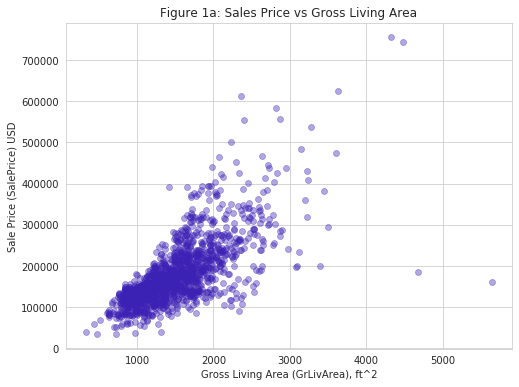

In [36]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
sns.set_style("whitegrid")

plt.figure(figsize = figsize1)

fig1 = sns.scatterplot(data = data, 
                       y='SalePrice', 
                       x='GrLivArea', 
                       alpha = 0.4, 
                       color = '#3c21b5',
                       edgecolor = None)

fig1.set(xlabel = "Gross Living Area (GrLivArea), ft^2", 
         ylabel = "Sale Price (SalePrice) USD", 
         title = "Figure 1a: Sales Price vs Gross Living Area"
        )

plt.show()

Sales prices and the gross living area show strong correlation. Several outliers are notable; the author recommends removing houses larger than 4,000 sq.ft.



In [37]:
# pre-removal
train['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

In [38]:
train = train[train['GrLivArea'] < 4000]

In [39]:
# post-removal
train['GrLivArea'].describe()

count    1456.000000
mean     1506.502060
std       496.815378
min       334.000000
25%      1128.000000
50%      1458.500000
75%      1775.250000
max      3627.000000
Name: GrLivArea, dtype: float64

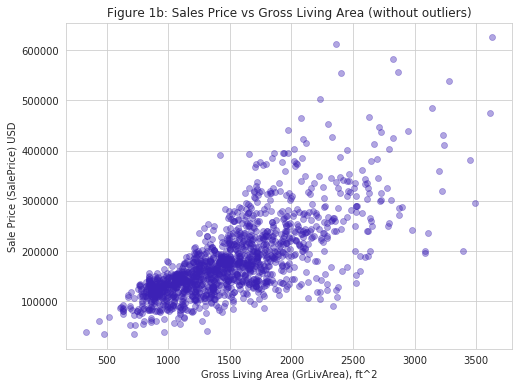

In [40]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)

plt.figure(figsize = figsize1)

fig1 = sns.scatterplot(data = data, 
                       y='SalePrice', 
                       x='GrLivArea', 
                       alpha = 0.4, 
                       color = '#3c21b5',
                       edgecolor = None)

fig1.set(xlabel = "Gross Living Area (GrLivArea), ft^2", 
         ylabel = "Sale Price (SalePrice) USD", 
         title = "Figure 1b: Sales Price vs Gross Living Area (without outliers)")


plt.show()

Like the houses, some lots are abnominally large:

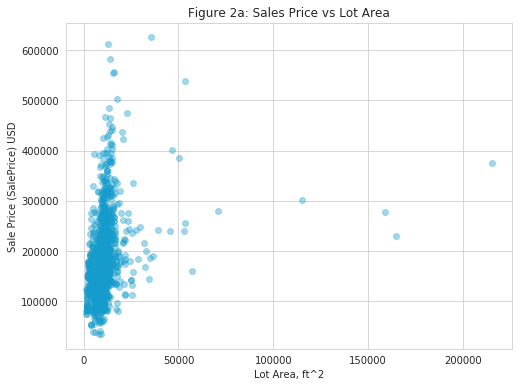

In [41]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)

plt.figure(figsize = figsize1)

fig2 = sns.scatterplot(data = data, 
                       y='SalePrice', 
                       x='LotArea', 
                       alpha = 0.4, 
                       color = '#169ccc',
                       edgecolor = None)

fig2.set(xlabel = "Lot Area, ft^2", 
         ylabel = "Sale Price (SalePrice) USD", 
         title = "Figure 2a: Sales Price vs Lot Area")


plt.show()

Remove lots with the area in excess of 100,000 sq.ft:

In [42]:
# pre-removal
train['LotArea'].describe()

count      1456.000000
mean      10448.784341
std        9860.763449
min        1300.000000
25%        7538.750000
50%        9468.500000
75%       11588.000000
max      215245.000000
Name: LotArea, dtype: float64

In [43]:
train = train[train['LotArea'] < 100000]

In [44]:
# post-removal
train['LotArea'].describe()

count     1452.000000
mean     10027.118457
std       5409.876086
min       1300.000000
25%       7526.250000
50%       9452.500000
75%      11515.500000
max      70761.000000
Name: LotArea, dtype: float64

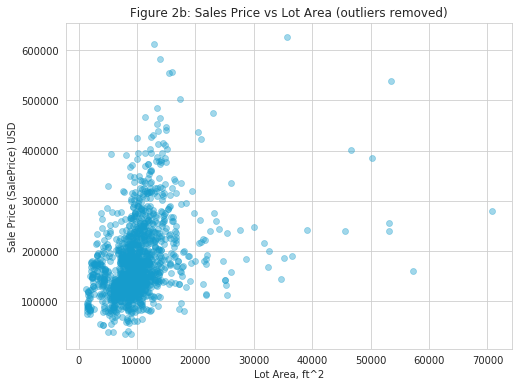

In [45]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)

plt.figure(figsize = figsize1)

fig2 = sns.scatterplot(data = data, 
                       y='SalePrice', 
                       x='LotArea', 
                       alpha = 0.4, 
                       color = '#169ccc',
                       edgecolor = None)

fig2.set(xlabel = "Lot Area, ft^2", 
         ylabel = "Sale Price (SalePrice) USD", 
         title = "Figure 2b: Sales Price vs Lot Area (outliers removed)")


plt.show()

## 2.4 Correlation Matrix

Study the relationship between the features and the target variable, crate the correlation matricies and the pairwise plots:

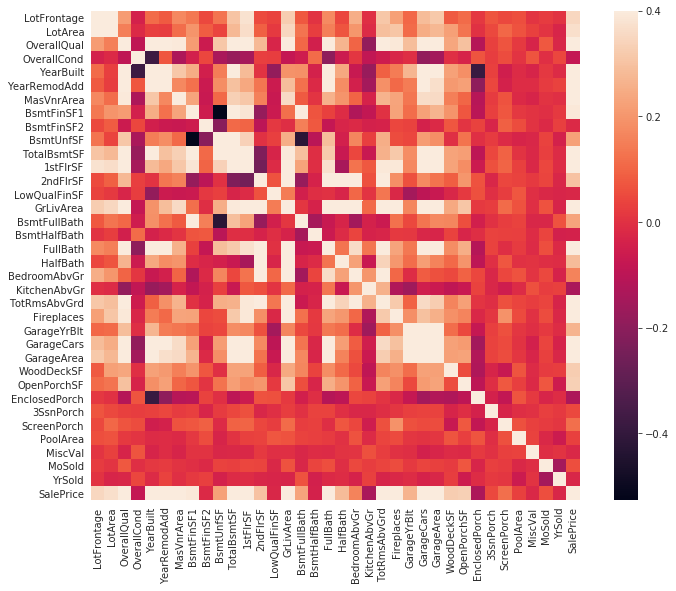

In [46]:
# create correlation matrix:

corrmat1 = train.corr()
plt.figure(figsize = (12, 9))

sns.heatmap(corrmat1, vmax=.4, square=True);

Create the pairwise plots:

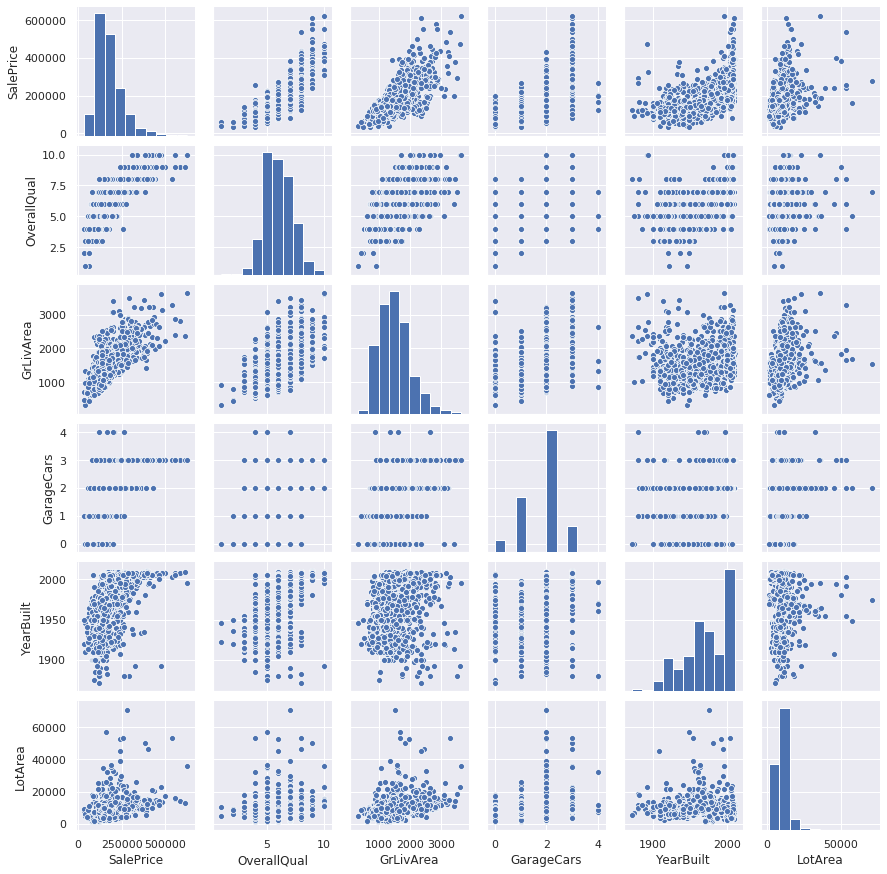

In [47]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'LotArea']
sns.pairplot(train[cols], height = 2)
plt.show();

Find the features with the highest correlation with the sale price:


In [48]:
corrmat1.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corrmat1.SalePrice)

SalePrice        1.000000
OverallQual      0.802832
GrLivArea        0.720183
GarageCars       0.650498
TotalBsmtSF      0.643992
GarageArea       0.638284
1stFlrSF         0.622602
FullBath         0.558330
TotRmsAbvGrd     0.538858
YearBuilt        0.538204
YearRemodAdd     0.524355
MasVnrArea       0.474481
Fireplaces       0.462500
BsmtFinSF1       0.392255
LotArea          0.369953
LotFrontage      0.349881
OpenPorchSF      0.332635
WoodDeckSF       0.324275
2ndFlrSF         0.300382
HalfBath         0.287392
GarageYrBlt      0.268481
BsmtFullBath     0.231024
BsmtUnfSF        0.224113
BedroomAbvGr     0.160909
ScreenPorch      0.119914
MoSold           0.057198
3SsnPorch        0.048081
PoolArea         0.033186
BsmtFinSF2      -0.017182
MiscVal         -0.022333
YrSold          -0.024207
LowQualFinSF    -0.024946
BsmtHalfBath    -0.039827
OverallCond     -0.080379
EnclosedPorch   -0.128790
KitchenAbvGr    -0.138502
Name: SalePrice, dtype: float64


The following features have the stronges correlation with sale price:

    Overall quality
    Gross living area
    Size of the garage
    Size of the basement



## 2.5 Vizualizing and Exploring the Key Variables:

As discovered in the previous section, the following numeric features have the stronges correlation with sale price:

    Overall quality
    Gross living area
    Size of the garage
    Size of the basement

### 2.5.1. Overall quality vs Sales price (#1, corr = 0.790982)


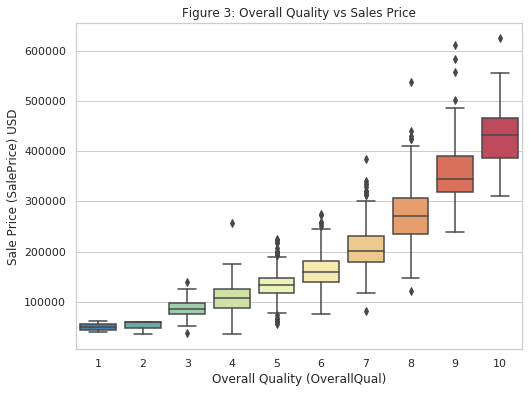

In [49]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)

plt.figure(figsize = figsize1)

sns.set_style("whitegrid")
sns.color_palette("hls", 10)

fig3 = sns.boxplot(data = data, 
                       y='SalePrice', 
                       x='OverallQual', 
                       palette = 'Spectral_r')

fig3.set(xlabel = "Overall Quality (OverallQual)", 
         ylabel = "Sale Price (SalePrice) USD", 
         title = "Figure 3: Overall Quality vs Sales Price")


plt.show()

* As expected, higher quality results in higher sale prices.

### 2.5.2 Sales price vs Gross Living Area (#2, corr = 0.708624)

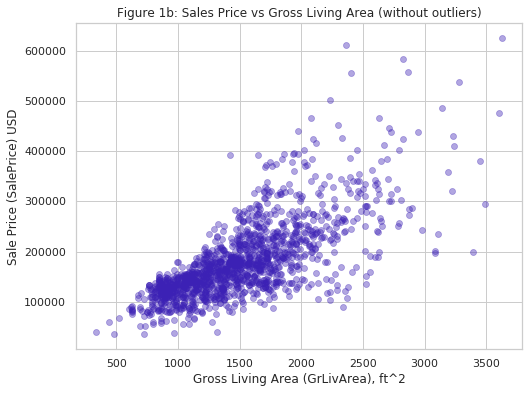

In [50]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)

plt.figure(figsize = figsize1)

fig1 = sns.scatterplot(data = data, 
                       y='SalePrice', 
                       x='GrLivArea', 
                       alpha = 0.4, 
                       color = '#3c21b5',
                       edgecolor = None)

fig1.set(xlabel = "Gross Living Area (GrLivArea), ft^2", 
         ylabel = "Sale Price (SalePrice) USD", 
         title = "Figure 1b: Sales Price vs Gross Living Area (without outliers)")


plt.show()

* Sales prices and the gross living area show strong correlation. 

### 2.5.3 Sales price vs Garage Size (GarageCars) (#3, corr = 0.640409)


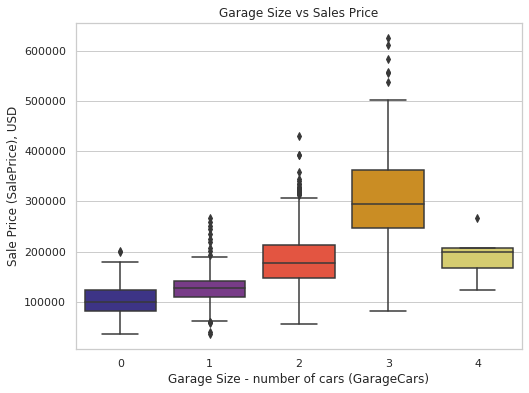

In [51]:
data = pd.concat([train['SalePrice'], train['GarageCars']], axis=1)

plt.figure(figsize = figsize1)


fig5 = sns.boxplot(x='GarageCars', 
                  y="SalePrice", 
                  data=data, 
                  palette = 'CMRmap')

fig5.set(title = 'Garage Size vs Sales Price', 
         xlabel = 'Garage Size - number of cars (GarageCars)', 
         ylabel = 'Sale Price (SalePrice), USD')

plt.show()

* As expected, houses with larger garages command the higher price. Exception: houses with 4-car garages.

### 2.5.4 Sales price vs total area of the basement

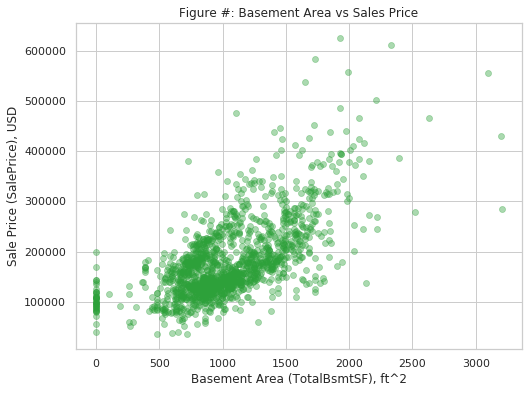

In [52]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)

plt.figure(figsize = figsize1)

fig1 = sns.scatterplot(data = data, 
                       y='SalePrice', 
                       x='TotalBsmtSF', 
                       alpha = 0.4, 
                       color = '#2da13a',
                       edgecolor = None)

fig1.set(xlabel = "Basement Area (TotalBsmtSF), ft^2", 
         ylabel = "Sale Price (SalePrice), USD", 
         title = "Figure #: Basement Area vs Sales Price")

plt.show()


* Sales prices and the gross basement area show strong correlation. 
* Some basements are quite large in area, exceeding 2500 sq. ft
* A number of properties don't have basements at all, as indicated by area = 0.

### 2.5.5. Sales Price vs Neighbourhood:

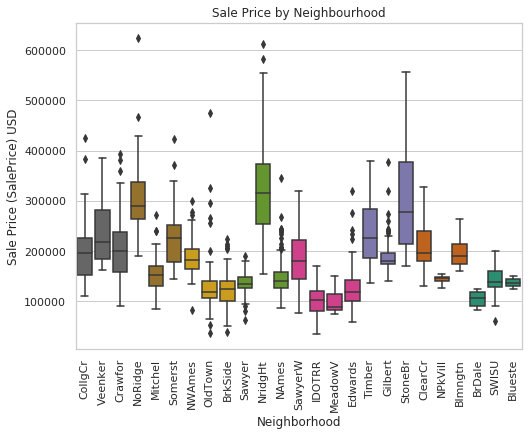

In [53]:
data = pd.concat([train['SalePrice'], train['Neighborhood']], axis=1)

plt.figure(figsize = figsize1)


fig = sns.boxplot(x='Neighborhood', y="SalePrice", data=data, palette = 'Dark2_r')

fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);

plt.title('Sale Price by Neighbourhood')
plt.ylabel("Sale Price (SalePrice) USD")
plt.show()


* The chart shows that prices vary greatly between the neighborhoods and within them.
* Northridge (NoRidge), Northridge Heights (NridHt) and Stone Brook (StoneBr) command the highest median prices

### 2.5.6 Sales price vs Year Built

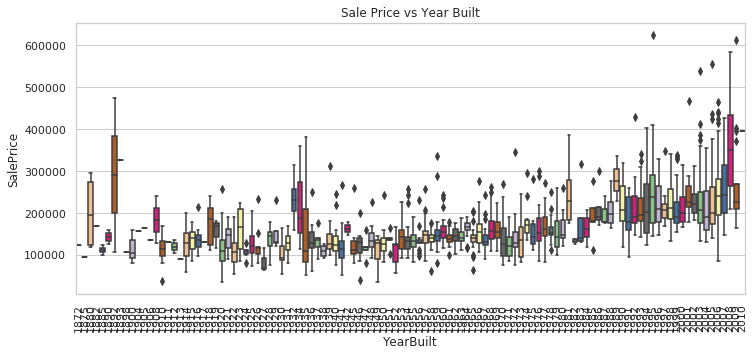

In [54]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
# f, ax = plt.subplots(figsize=(10, 5))

plt.figure(figsize = (12, 5))

fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=data, palette = 'Accent')
fig.set_title('Sale Price vs Year Built')

fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);


* The chart shows that newer homes generally command higher prices. Exception are the houses built in late 1800s and 1930s

## 2.6. Investigation of the Target Variable - Sales Price


Visualize the target variable - Sales Price

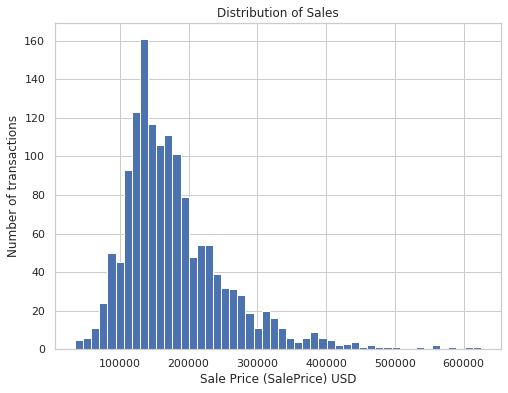

In [55]:
plt.figure(figsize = figsize1)

train['SalePrice'].hist(bins = 50, rwidth = 1)

plt.title('Distribution of Sales')
plt.xlabel("Sale Price (SalePrice) USD")
plt.ylabel("Number of transactions")

plt.show()

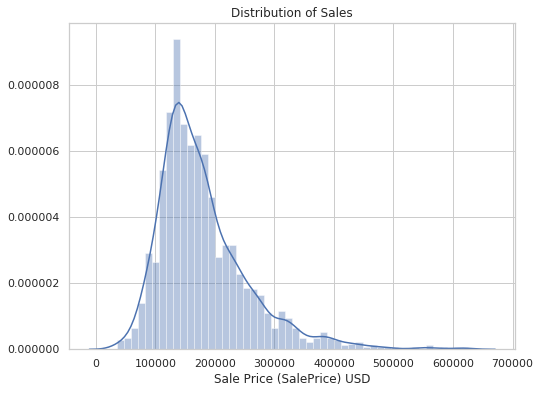

In [56]:
plt.figure(figsize = figsize1)

sns.distplot(train['SalePrice'], bins = 50)

plt.title('Distribution of Sales')
plt.xlabel("Sale Price (SalePrice) USD")

plt.show()

Get the numeric parameters of the target variable - Sales Price:

In [57]:
train['SalePrice'].describe()

count      1452.000000
mean     179832.814050
std       76511.297631
min       34900.000000
25%      129900.000000
50%      162900.000000
75%      213492.500000
max      625000.000000
Name: SalePrice, dtype: float64

In [58]:
print('Skew: {0:9.3f}'.format(train['SalePrice'].skew()))
print('Kurtosis: {0:5.3f}'.format(train['SalePrice'].kurtosis(), width = 10))

Skew:     1.578
Kurtosis: 3.962


* The distribution deviates from normal distribution, it is positively skewed with significant outliers.

Perform a log(1+x) transformation:

In [59]:
train["SalePriceLog"] = np.log1p(train["SalePrice"])


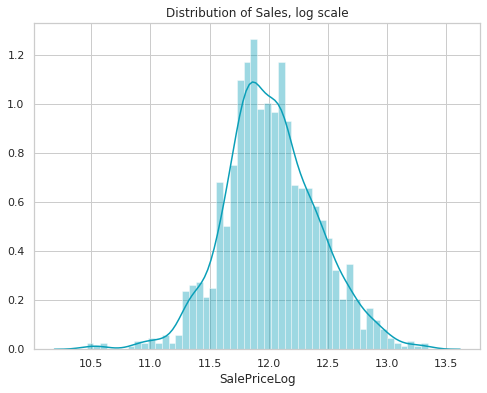

In [60]:
plt.figure(figsize = figsize1)

sns.set_style("whitegrid")

plt.title('Distribution of Sales, log scale')
sns.distplot(train.SalePriceLog, bins = 50, color = '#0a9fb8');
plt.show()

In [61]:
print('Skew: {0:9.3f}'.format(train['SalePriceLog'].skew()))
print('Kurtosis: {0:5.3f}'.format(train['SalePriceLog'].kurtosis(), width = 10))

Skew:     0.067
Kurtosis: 0.684


* new distribution is approximately normal

# 3. Modeling

## 3.1 Preparation

### 3.1.1.  Taking log-transformed Sales Price as the target variable:

In [62]:
y = train['SalePriceLog']

### 3.1.2 Dropping Sales Price and log-transformed Sales price from the training dataset:

In [63]:
train = train.drop(['SalePrice', 'SalePriceLog'], axis = 1)

In [64]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,Class60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,Class20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,Class60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal


### 3.1.3. Divide the dataset into categorical and numeric:

In [65]:
cat_feat = train.select_dtypes(include = ["object"]).columns
num_feat = train.select_dtypes(exclude = ["object"]).columns

train_num_feat = train[num_feat]
train_cat_feat = train[cat_feat]

In [66]:
print("Numerical features : " + str(len(num_feat)))
for col in train_num_feat:
    print(col)

Numerical features : 35
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold


In [67]:
print("Categoric features : " + str(len(cat_feat)))
for col in train_cat_feat:
    print(col)

Categoric features : 39
MSSubClass
MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
SaleType
SaleCondition


### 3.1.4. Encode categorical features by using OneHotEncoder:

In [68]:
train_cat_feat.head(3)

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,Class60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,Class20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,Class60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [69]:
train_cat_feat_hotcoded = pd.get_dummies(train_cat_feat)

In [70]:
train_cat_feat_hotcoded.head(3)

,MSSubClass_Class120,MSSubClass_Class160,MSSubClass_Class180,MSSubClass_Class190,MSSubClass_Class20,MSSubClass_Class30,MSSubClass_Class40,MSSubClass_Class45,MSSubClass_Class50,MSSubClass_Class60,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


### 3.1.5 Merge the numeric and categorical features into one dataset:

In [71]:
# join the features into one dataset
df_train = pd.concat([train_cat_feat_hotcoded, train_num_feat], axis = 1)

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1459
Columns: 292 entries, MSSubClass_Class120 to YrSold
dtypes: float64(2), int64(33), uint8(257)
memory usage: 812.8 KB


In [73]:
df_train.head()

,MSSubClass_Class120,MSSubClass_Class160,MSSubClass_Class180,MSSubClass_Class190,MSSubClass_Class20,MSSubClass_Class30,MSSubClass_Class40,MSSubClass_Class45,MSSubClass_Class50,MSSubClass_Class60,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0,0,0,0,0,0,0,0,0,1,...,548,0,61,0,0,0,0,0,2,2008
1,0,0,0,0,1,0,0,0,0,0,...,460,298,0,0,0,0,0,0,5,2007
2,0,0,0,0,0,0,0,0,0,1,...,608,0,42,0,0,0,0,0,9,2008
3,0,0,0,0,0,0,0,0,0,0,...,642,0,35,272,0,0,0,0,2,2006
4,0,0,0,0,0,0,0,0,0,1,...,836,192,84,0,0,0,0,0,12,2008


### 3.1.6 Split the dataset into training and test sets

Establish the train - test split ratio:

In [74]:
test_ratio = 0.25

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size = test_ratio, random_state = 1)

In [76]:
X_train.shape

(1089, 292)

In [77]:
y_train.shape

(1089,)

In [78]:
X_test.shape

(363, 292)

In [79]:
y_test.shape

(363,)

## 3.2. Linear regression:

In [80]:
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Make predictions on the train data:

In [81]:
y_train_lreg = l_reg.predict(X_train)
y_test_lreg = l_reg.predict(X_test)

In [82]:
X_train.shape

(1089, 292)

In [83]:
X_test.shape

(363, 292)

In [84]:
y_train_lreg.shape

(1089,)

In [85]:
y_test_lreg.shape

(363,)

Compare the actual output values with the predicted values:

In [86]:
pred_vs_actual_train = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_lreg})

In [87]:
pred_vs_actual_train

,Actual,Predicted
858,11.931642,11.899088
353,11.570260,11.567643
1374,12.429220,12.435217
702,12.799178,12.859422
202,11.626263,11.651571
...,...,...
721,11.870607,11.852555
911,11.874097,11.926244
1102,11.813037,11.822573
235,11.402005,11.436534


In [88]:
pred_vs_actual_test = pd.DataFrame({'Actual test': y_test, 'Predicted': y_test_lreg})

In [89]:
pred_vs_actual_test

,Actual test,Predicted
635,12.206078,12.020863
535,11.585255,11.799602
1096,11.751950,11.764122
563,12.128117,11.978004
37,11.938200,11.941171
...,...,...
1041,12.061053,12.024051
463,12.147919,12.098265
304,12.594734,12.501104
1266,11.711785,11.594529


In [90]:
print('Stats for training set:')
print('Mean Absolute Error: {0:11.5f}'.format(metrics.mean_absolute_error(y_train, y_train_lreg)))  
print('Mean Squared Error: {0:12.5f}'.format(metrics.mean_squared_error(y_train, y_train_lreg)))
print('Root Mean Squared Error: {0:4.5f}'.format(metrics.mean_squared_error(y_train, y_train_lreg, squared = False)))

Stats for training set:
Mean Absolute Error:     0.05940
Mean Squared Error:      0.00683
Root Mean Squared Error: 0.08265


* Very good performance on the train set

In [91]:
print('Stats for test set:')
print('Mean Absolute Error: {0:11.5f}'.format(metrics.mean_absolute_error(y_test, y_test_lreg)))  
print('Mean Squared Error: {0:12.5f}'.format(metrics.mean_squared_error(y_test, y_test_lreg)))  
print('Root Mean Squared Error: {0:4.5f}'.format(metrics.mean_squared_error(y_test, y_test_lreg, squared = False)))

Stats for test set:
Mean Absolute Error:     0.08947
Mean Squared Error:      0.01846
Root Mean Squared Error: 0.13588


Save the metrics of the evaluations for every model:

In [92]:
scores = pd.DataFrame(columns = ['linear', 'ridge', 'xgb'])

In [93]:
scores['linear'] = pd.Series({'MAE ': metrics.mean_absolute_error(y_test, y_test_lreg),
                              'MSE ': metrics.mean_squared_error(y_test, y_test_lreg),
                              'RMSE': metrics.mean_squared_error(y_test, y_test_lreg, squared = False)})

In [94]:
scores

,linear,ridge,xgb
MAE,0.089472,NaN,NaN
MSE,0.018464,NaN,NaN
RMSE,0.135881,NaN,NaN


Plot actual vs predicted values:

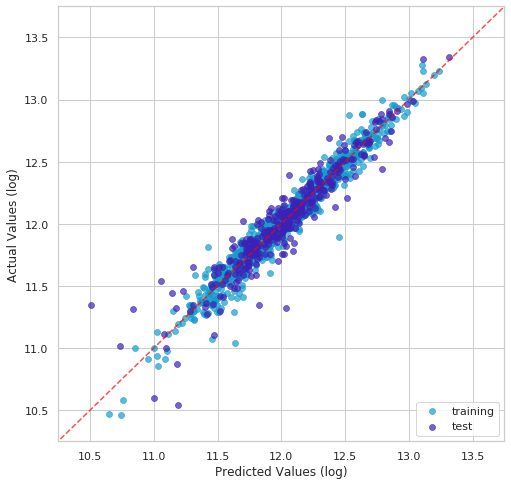

In [95]:
figure, axes = plt.subplots(figsize = (8, 8))
sns.set_style("whitegrid")


fig5 = sns.scatterplot(x=y_train_lreg, 
                       y=y_train, 
                       label = 'training', 
                       alpha = 0.7, 
                       color = '#169ccc', 
                       edgecolor = None)

sns.scatterplot(x=y_test_lreg, 
                y=y_test, 
                label = 'test',
                alpha = 0.7, 
                color = '#3c21b5', 
                edgecolor = None)

plt.plot([10, 14], [10, 14], c = "red", alpha = 0.7, linestyle = '--')


fig5.set(xlabel = "Predicted Values (log)", 
         ylabel = "Actual Values (log)", 
         #title = "Figure #: Predicted vs actual values (linear reg)")
        )
plt.legend(loc = "lower right")

axes.set_xlim(10.25, 13.75)
axes.set_ylim(10.25, 13.75)

plt.show()

Plot residuals vs predictions for training and test sets:

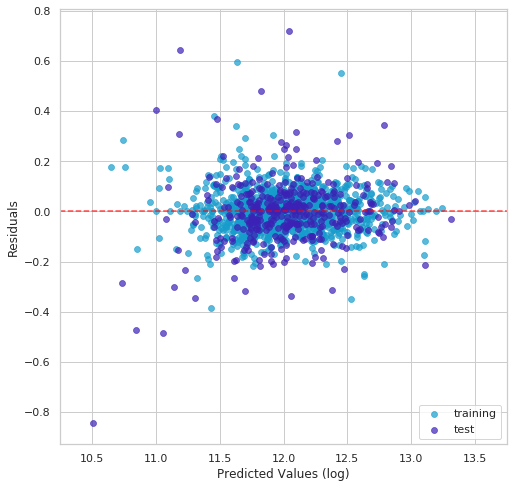

In [96]:
figure, axes = plt.subplots(figsize = (8, 8 ))
sns.set_style("whitegrid")

fig4 = sns.scatterplot(x=y_train_lreg, 
                       y=y_train_lreg - y_train, 
                       label = 'training', 
                       alpha = 0.7, 
                       color = '#169ccc', 
                       edgecolor = None)

sns.scatterplot(x=y_test_lreg, 
                y=y_test_lreg - y_test, 
                label = 'test',
                alpha = 0.7, 
                color = '#3c21b5', 
                edgecolor = None)

plt.plot([10, 14], [0, 0], c = "red", alpha = 0.7, linestyle = '--')


fig4.set(xlabel = "Predicted Values (log)", 
         ylabel = "Residuals", 
         #title = "Figure 4: Predicted values vs residuals (linear reg)"
        )

plt.legend(loc = "lower right")


#axes.set_ylim(-0.5, 0.5)
axes.set_xlim(10.25, 13.75)

plt.show()

## 3.3. Ridge Regression 

In [97]:
# define the model and the search parameters:
# search grid from 10e-5 to 10e^2, logspace
grid = dict()
grid['alpha'] = np.logspace(-5, 2, 15) # 7*n + 8 = (8, 15, 22, 29, 36, 43, 50 ...)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge = Ridge(grid)

In [98]:
# define search
search = GridSearchCV(ridge, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, y_train)
better_alpha = results.best_params_['alpha']

print('RMSE: {0:15.5f}'.format(results.best_score_*(-1)))
print('ridge alpha: {0:3.1f}'.format(better_alpha))

RMSE:         0.11090
ridge alpha: 10.0


In [99]:
alpha = better_alpha

The optimal alpha is ~ 10.0. Run the model with this alpha:

In [100]:
ridge = Ridge(better_alpha)

In [101]:
ridge.fit(X_train, y_train)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [102]:
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_test)

In [103]:
print('Stats for train set:')
print('Mean Absolute Error: {0:11.5f}'.format(metrics.mean_absolute_error(y_train, y_train_ridge)))  
print('Mean Squared Error: {0:12.5f}'.format(metrics.mean_squared_error(y_train, y_train_ridge)))  
print('Root Mean Squared Error: {0:4.5f}'.format(metrics.mean_squared_error(y_train, y_train_ridge, squared = False)))

Stats for train set:
Mean Absolute Error:     0.06487
Mean Squared Error:      0.00837
Root Mean Squared Error: 0.09148


In [104]:
print('Stats for test set:')
print('Mean Absolute Error: {0:11.5f}'.format(metrics.mean_absolute_error(y_test, y_test_ridge)))  
print('Mean Squared Error: {0:12.5f}'.format(metrics.mean_squared_error(y_test, y_test_ridge)))  
print('Root Mean Squared Error: {0:4.5f}'.format(metrics.mean_squared_error(y_test, y_test_ridge, squared = False)))

Stats for test set:
Mean Absolute Error:     0.07824
Mean Squared Error:      0.01370
Root Mean Squared Error: 0.11704


In [105]:
scores['ridge'] = pd.Series({'MAE ': metrics.mean_absolute_error(y_test, y_test_ridge),
                              'MSE ': metrics.mean_squared_error(y_test, y_test_ridge),
                              'RMSE': metrics.mean_squared_error(y_test, y_test_ridge, squared = False)})

In [106]:
scores

,linear,ridge,xgb
MAE,0.089472,0.078245,NaN
MSE,0.018464,0.013698,NaN
RMSE,0.135881,0.117038,NaN


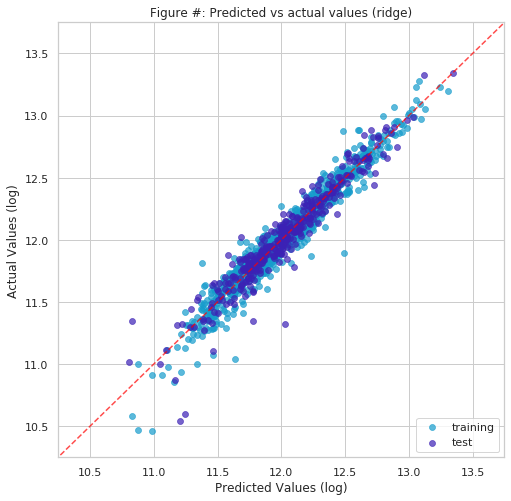

In [107]:
figure, axes = plt.subplots(figsize = (8, 8))
sns.set_style("whitegrid")


fig5 = sns.scatterplot(x=y_train_ridge, 
                       y=y_train, 
                       label = 'training', 
                       alpha = 0.7, 
                       color = '#169ccc', 
                       edgecolor = None)

sns.scatterplot(x=y_test_ridge, 
                y=y_test, 
                label = 'test',
                alpha = 0.7, 
                color = '#3c21b5', 
                edgecolor = None)

plt.plot([10, 14], [10, 14], c = "red", alpha = 0.7, linestyle = '--')


fig5.set(xlabel = "Predicted Values (log)", 
         ylabel = "Actual Values (log)", 
         title = "Figure #: Predicted vs actual values (ridge)")

plt.legend(loc = "lower right")


#axes.set_ylim(-0.5, 0.5)
axes.set_xlim(10.25, 13.75)
axes.set_ylim(10.25, 13.75)


plt.show()

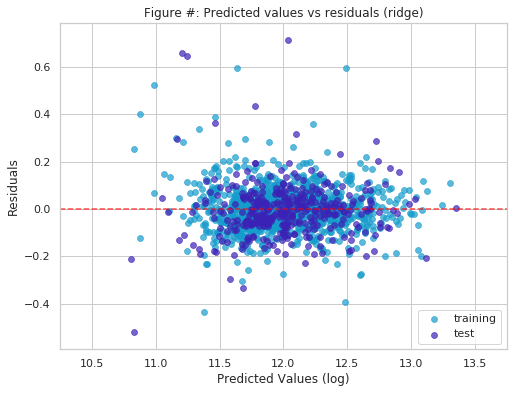

In [108]:
figure, axes = plt.subplots(figsize = figsize1)

fig4 = sns.scatterplot(x=y_train_ridge, 
                       y=y_train_ridge - y_train, 
                       label = 'training', 
                       alpha = 0.7, 
                       color = '#169ccc', 
                       edgecolor = None)

sns.scatterplot(x=y_test_ridge, 
                y=y_test_ridge - y_test, 
                label = 'test',
                alpha = 0.7, 
                color = '#3c21b5', 
                edgecolor = None)

plt.plot([10, 14], [0, 0], c = "red", alpha = 0.7, linestyle = '--')


fig4.set(xlabel = "Predicted Values (log)", 
         ylabel = "Residuals", 
         title = "Figure #: Predicted values vs residuals (ridge)")

plt.legend(loc = "lower right")


#axes.set_ylim(-0.5, 0.5)
axes.set_xlim(10.25, 13.75)

plt.show()

Ridge incorporated 287features
Ridge eliminated 5 features


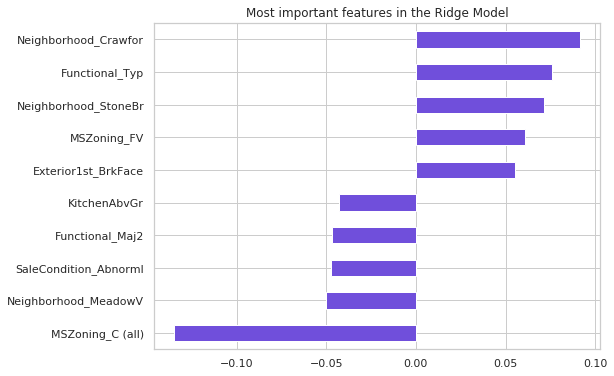

In [109]:
figure, axes = plt.subplots(figsize = figsize1)


coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge incorporated " + str(sum(coefs != 0)) + "features")
print("Ridge eliminated " +  str(sum(coefs == 0)) + " features")
important_coefs = pd.concat([coefs.sort_values().head(5),
                     coefs.sort_values().tail(5)])
important_coefs.plot(kind = "barh", color = '#704fdb')
plt.title("Most important features in the Ridge Model")
plt.show()

# 3.5 Extreme Gradient Boosting

In [110]:
model2 = XGBRegressor(base_score=0.5, 
                      booster='gbtree', 
                      colsample_bylevel=1, 
                      colsample_bytree=1, 
                      gamma=0, 
                      learning_rate=0.01, 
                      max_delta_step=0,
                      max_depth=3, 
                      min_child_weight=1, 
                      missing=None, 
                      n_estimators=5000, 
                      n_jobs=1, 
                      nthread=8, 
                      objective='reg:squarederror', 
                      random_state=0,
                      reg_alpha=0.00001, 
                      reg_lambda=1, 
                      scale_pos_weight=1, 
                      seed=0, 
                      subsample=0.8)


In [111]:
model2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=5000, n_jobs=1, nthread=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=1e-05,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
y_train_xgb = model2.predict(X_train)
y_test_xgb = model2.predict(X_test)

In [113]:
print('Stats for train set (XGB):')
print('Mean Absolute Error: {0:11.5f}'.format(metrics.mean_absolute_error(y_train, y_train_xgb)))  
print('Mean Squared Error: {0:12.5f}'.format(metrics.mean_squared_error(y_train, y_train_xgb)))  
print('Root Mean Squared Error: {0:4.5f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_xgb))))

Stats for train set (XGB):
Mean Absolute Error:     0.02383
Mean Squared Error:      0.00097
Root Mean Squared Error: 0.03121


In [114]:
print('Stats for test set (XGB):')
print('Mean Absolute Error: {0:11.5f}'.format(metrics.mean_absolute_error(y_test, y_test_xgb)))  
print('Mean Squared Error: {0:12.5f}'.format(metrics.mean_squared_error(y_test, y_test_xgb)))  
print('Root Mean Squared Error: {0:4.5f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_xgb))))

Stats for test set (XGB):
Mean Absolute Error:     0.07635
Mean Squared Error:      0.01339
Root Mean Squared Error: 0.11570


In [115]:
scores['xgb'] = pd.Series({'MAE ': metrics.mean_absolute_error(y_test, y_test_xgb),
                              'MSE ': metrics.mean_squared_error(y_test, y_test_xgb),
                              'RMSE': metrics.mean_squared_error(y_test, y_test_xgb, squared = False)})

In [116]:
scores

,linear,ridge,xgb
MAE,0.089472,0.078245,0.076349
MSE,0.018464,0.013698,0.013387
RMSE,0.135881,0.117038,0.115703


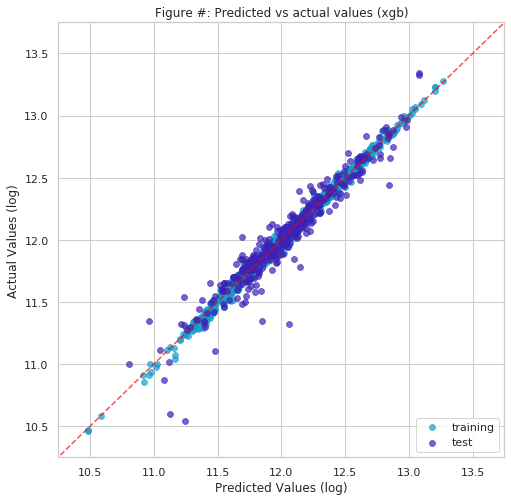

In [117]:
figure, axes = plt.subplots(figsize = (8, 8))
sns.set_style("whitegrid")


fig5 = sns.scatterplot(x=y_train_xgb, 
                       y=y_train, 
                       label = 'training', 
                       alpha = 0.7, 
                       color = '#169ccc', 
                       edgecolor = None)

sns.scatterplot(x=y_test_xgb, 
                y=y_test, 
                label = 'test',
                alpha = 0.7, 
                color = '#3c21b5', 
                edgecolor = None)

plt.plot([10, 14], [10, 14], c = "red", alpha = 0.7, linestyle = '--')


fig5.set(xlabel = "Predicted Values (log)", 
         ylabel = "Actual Values (log)", 
         title = "Figure #: Predicted vs actual values (xgb)")

plt.legend(loc = "lower right")


#axes.set_ylim(-0.5, 0.5)
axes.set_xlim(10.25, 13.75)
axes.set_ylim(10.25, 13.75)


plt.show()

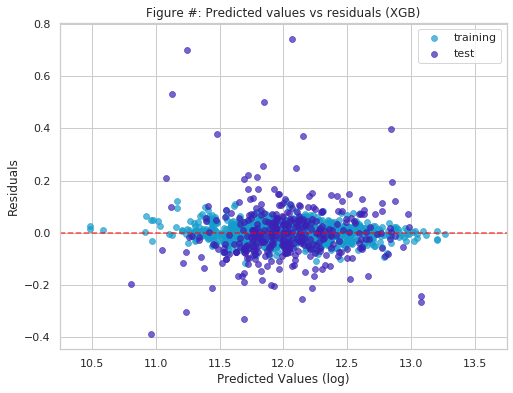

In [118]:
figure, axes = plt.subplots(figsize = figsize1)

fig4 = sns.scatterplot(x=y_train_xgb, 
                       y=y_train_xgb - y_train, 
                       label = 'training', 
                       alpha = 0.7, 
                       color = '#169ccc', 
                       edgecolor = None)

sns.scatterplot(x=y_test_xgb, 
                y=y_test_xgb - y_test, 
                label = 'test',
                alpha = 0.7, 
                color = '#3c21b5', 
                edgecolor = None)

plt.plot([10, 14], [0, 0], c = "red", alpha = 0.7, linestyle = '--')


fig4.set(xlabel = "Predicted Values (log)", 
         ylabel = "Residuals", 
         title = "Figure #: Predicted values vs residuals (XGB)")

plt.legend(loc = "upper right")


#axes.set_ylim(-0.5, 0.5)
axes.set_xlim(10.25, 13.75)

plt.show()

# 4. Summary and Conclusions

How well the model predicts the data? Evaluate RMSE and select the optimal model

In [119]:
scores

,linear,ridge,xgb
MAE,0.089472,0.078245,0.076349
MSE,0.018464,0.013698,0.013387
RMSE,0.135881,0.117038,0.115703


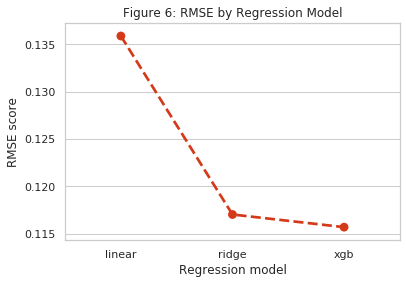

In [120]:
fig = sns.pointplot(x=list(scores.keys()), 
                    y=scores.iloc[2, ], label = 'RMSE',
                    markers=['o'], 
                    linestyles=['--'], 
                    alpha = 0.7, 
                    color = '#d43a19')

fig.set(xlabel = "Regression model", 
         ylabel = "RMSE score", 
         title = "Figure 6: RMSE by Regression Model")


plt.show()


* XGB model has the best RMSE score, followed by ridge and linear regression
* good approximation of the house value with RSME of ~0.115